## Get Active count of After Hour Variances

In [1]:
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import geopandas as gpd
import datetime
import matplotlib
from itertools import product
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy

import sys
sys.path.insert(0, '/Users/sunghoonyang/PycharmProjects/noise-capstone/analysis/311/duke')

from datetime import datetime
from dateutil.relativedelta import relativedelta

# precipitation data
from prep_dta import _2010, _2011, _2012, _2013, _2014, _2015, _2016, _2017, _2018
from american_holidays import american_holidays as _american_holidays_str
%matplotlib inline

In [52]:
shp = gpd.read_file('/Users/sunghoonyang/Google Drive/Noise Capstone/data/Neighborhood Tabulation Areas/geo_export_734cc588-a881-4394-bdd7-9f757b306aa4.shp')

In [3]:
ahv = pd.read_csv('/Users/sunghoonyang/Google Drive/Noise Capstone/data/AfterHourVariance_lat_long.csv')
ahv.head()

/Users/sunghoonyang/PycharmProjects/ds_workspace/Noise Capstone/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,timestamp,bbl,borough,block,lot,bin,premises,jobno,referenceno,permitno,jobtype,efiled,feeexempt,filingtype,daysbilled,status,totalfee,houseno,streetname,floors,cbno,contractorname,contractorbusinessname,contractorbusinessaddr,contractorlicensetype,contractorphone,contractorlicense,residencewithin200feet,workwithinenclosedbuilding,fullorpatialdemolition,craneuse,daysrequested,daysapproved,approvedfor,erenew,applyreason,approved,erenewalauthorized,description,range,count,centroid,lon,lat
0,2011-02-06 10:00:00-05:00,1012880056,MANHATTAN,1288,56,1088582,14 EAST 53 STREET MANHATTAN,104747115,100,104747115,NB,NaN,No,Initial,2,AHV SUCCESSFULLY ISSUED,$260.00,510,MADISON AVENUE,1,105.0,WILLIAM MOTHERWAY,TISHMAN CONSTRUCTION CORP,666 FIFTH AVENUE NEW YORK NY 10103,GC,631-724-5915,2540,False,False,False,False,2,2,"02/05/2011,Saturday,10:00 AM,5:00 PM;02/06/201...",Yes,PUBLIC SAFETY,DEBRIS REMOVAL,"Saturday 10:00 AM to 5:00 PM, Sunday 10:00 AM ...",NaN,"[{u'start': 2011-02-05 10:00:00-05:00, u'end':...",1,"(40.7596705219, -73.9747348344)",40.759671,-73.974735
1,2011-02-10 18:00:00-05:00,1007870044,MANHATTAN,787,44,1014460,508 7 AVENUE MANHATTAN,120537348,400009,120537348,A2,NaN,No,Initial,3,AHV SUCCESSFULLY ISSUED,$340.00,512,SEVENTH AVENUE,"33, 34",105.0,BRIAN GREEN,ARTISAN CONSTR PARTNERS L,"65 WEST 37TH STREET, #300 NEW YORK NY 10018",GC,212-840-8500,603945,False,False,False,False,3,3,"02/08/2011,Tuesday,6:00 PM,12:00 AM;02/09/2011...",Yes,PUBLIC SAFETY,BUSINESS HOURS OPERATIONS INTERRUPTION,"Tuesday 6:00 PM to 12:00 AM, Wednesday 6:00 PM...",REMOVE INTERIOR PARTITIONS,"[{u'start': 2011-02-08 18:00:00-05:00, u'end':...",1,"(40.7534042442, -73.9893360555)",40.753404,-73.989336
2,2011-02-10 18:00:00-05:00,1005540001,MANHATTAN,554,1,1008952,770 BROADWAY MANHATTAN,120419608,400173,120419608,A2,NaN,No,Initial,3,AHV SUCCESSFULLY ISSUED,$340.00,770,BROADWAY,"10, 11, 12",102.0,DAVID STORY,TRINITY BUILDING AND CONS,1 JEWEL DRIVE #322 WILMINGTON MA 01887,GC,781-938-0008,37220,False,False,False,False,3,3,"02/09/2011,Wednesday,6:00 PM,3:00 AM;02/10/201...",Yes,PUBLIC SAFETY,BUSINESS HOURS OPERATIONS INTERRUPTION,"Wednesday 6:00 PM to 3:00 AM, Thursday 6:00 PM...","STEEL WELDING, SITE CLEAN UP","[{u'start': 2011-02-09 18:00:00-05:00, u'end':...",1,"(40.7306014266, -73.9913758691)",40.730601,-73.991376
3,2011-02-10 18:00:00-05:00,1013090001,MANHATTAN,1309,1,1036476,405 PARK AVENUE MANHATTAN,120550849,400064,120550849,A2,NaN,No,Initial,2,AHV SUCCESSFULLY ISSUED,$260.00,405,PARK AVENUE,12,105.0,BRIAN ROTHSCHILD,ENVIROCHROME INTERIORS IN,80 PARK AVENUE NEW YORK NY 10016,GC,212-687-7330,19046,False,False,False,False,2,2,"02/10/2011,Thursday,6:00 PM,6:00 AM;",Yes,PUBLIC SAFETY,BUSINESS HOURS OPERATIONS INTERRUPTION,Thursday 6:00 PM to 6:00 AM,"MINOR DEMOLITION OF PARTITIONS, DOORS, SUSPEND...","[{u'start': 2011-02-10 18:00:00-05:00, u'end':...",1,"(40.7597358049, -73.9716172608)",40.759736,-73.971617
4,2011-02-11 18:00:00-05:00,1017190001,MANHATTAN,1719,1,1083967,18 MT MORRIS PARK WEST MANHATTAN,120088939,400013,120088939,A2,NaN,No,Initial,4,AHV SUCCESSFULLY ISSUED,$520.00,18,MT. MORRIS PARK WEST,1,111.0,JOHN DRISCOU,TRITON STRUCTURAL CONCRET,15435 INNOVATION DR #225 SAN DIEGO CA 92121,GC,347-423-6618,604939,False,False,False,False,4,4,"02/08/2011,Tuesday,6:00 PM,12:00 AM;02/09/2011...",Yes,PUBLIC SAFETY,TRAFFIC CONGESTION (PEDESTRIAN AND/OR VEHICULAR),"Tuesday 6:00 PM to 12:00 AM, Wednesday 6:00 PM...","MOVING OF MATERIALS, INSTALLATION OF ROOFING S...","[{u'start': 2011-02-08 18:00:00-05:00, u'end':...",1,"(40.8045998935, -73.943228267)",40.804600,-73.943228


Is column range supposed to be json? the timestamps are illegal and not enclosed. cleansing necessary

In [43]:
import re

def correct_json(s):
    s = re.sub("-\d\d:\d\d","'", s)
    s = s.replace("start': ", "start': '")    
    s = s.replace("end': ", "end': '")        
    s = s.replace("u'", "'")    
    return s

ahv['range_json'] = ahv['range'].apply(correct_json)
ahv[['range_json', 'range']].head(20)

join with nta shape

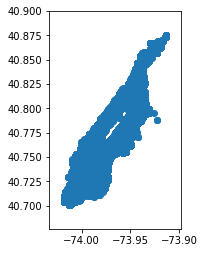

In [55]:
from shapely.geometry import Point

crs = {'init': 'epsg:4326'}
df = ahv.copy(deep=True)

def _return_pt(xy):
    try:
        return Point(*reversed(eval(str(xy))))
    except:
        return np.nan

df['geom'] = df['centroid'].apply(_return_pt)
df.head()
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='geom')
gdf.plot()

In [57]:
j_view = gpd.sjoin(
    gdf
    , shp
    , op='within'
)

j_view.head()

,timestamp,bbl,borough,block,lot,bin,premises,jobno,referenceno,permitno,jobtype,efiled,feeexempt,filingtype,daysbilled,status,totalfee,houseno,streetname,floors,cbno,contractorname,contractorbusinessname,contractorbusinessaddr,contractorlicensetype,contractorphone,contractorlicense,residencewithin200feet,workwithinenclosedbuilding,fullorpatialdemolition,craneuse,daysrequested,daysapproved,approvedfor,erenew,applyreason,approved,erenewalauthorized,description,range,count,centroid,lon,lat,range_dts,range_json,geom,index_right,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng
0,2011-02-06 10:00:00-05:00,1012880056,MANHATTAN,1288,56,1088582,14 EAST 53 STREET MANHATTAN,104747115,100,104747115,NB,NaN,No,Initial,2,AHV SUCCESSFULLY ISSUED,$260.00,510,MADISON AVENUE,1,105.0,WILLIAM MOTHERWAY,TISHMAN CONSTRUCTION CORP,666 FIFTH AVENUE NEW YORK NY 10103,GC,631-724-5915,2540,False,False,False,False,2,2,"02/05/2011,Saturday,10:00 AM,5:00 PM;02/06/201...",Yes,PUBLIC SAFETY,DEBRIS REMOVAL,"Saturday 10:00 AM to 5:00 PM, Sunday 10:00 AM ...",NaN,"[{u'start': 2011-02-05 10:00:00-05:00, u'end':...",1,"(40.7596705219, -73.9747348344)",40.759671,-73.974735,2,"[{'start': '2011-02-05 10:00:00', 'end': '2011...",POINT (-73.9747348344 40.7596705219),107,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700433
1,2011-02-10 18:00:00-05:00,1007870044,MANHATTAN,787,44,1014460,508 7 AVENUE MANHATTAN,120537348,400009,120537348,A2,NaN,No,Initial,3,AHV SUCCESSFULLY ISSUED,$340.00,512,SEVENTH AVENUE,"33, 34",105.0,BRIAN GREEN,ARTISAN CONSTR PARTNERS L,"65 WEST 37TH STREET, #300 NEW YORK NY 10018",GC,212-840-8500,603945,False,False,False,False,3,3,"02/08/2011,Tuesday,6:00 PM,12:00 AM;02/09/2011...",Yes,PUBLIC SAFETY,BUSINESS HOURS OPERATIONS INTERRUPTION,"Tuesday 6:00 PM to 12:00 AM, Wednesday 6:00 PM...",REMOVE INTERIOR PARTITIONS,"[{u'start': 2011-02-08 18:00:00-05:00, u'end':...",1,"(40.7534042442, -73.9893360555)",40.753404,-73.989336,3,"[{'start': '2011-02-08 18:00:00', 'end': '2011...",POINT (-73.9893360555 40.7534042442),107,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700433
7,2011-02-11 18:00:00-05:00,1012657501,MANHATTAN,1265,7501,1076262,30 ROCKEFELLER PLAZA MANHATTAN,120592956,400015,120592956,A2,NaN,No,Initial,4,AHV SUCCESSFULLY ISSUED,$520.00,30,ROCKEFELLER PLAZA,"40, 42",105.0,MICHAEL MARRONE,W5 GROUP LLC,50 E. PALISADE AVE. STE.111 WALDORF DEMOLITION...,GC,201-541-0030,35038,False,False,False,False,4,4,"02/08/2011,Tuesday,6:00 PM,12:00 AM;02/09/2011...",Yes,PUBLIC SAFETY,BUSINESS HOURS OPERATIONS INTERRUPTION,"Tuesday 6:00 PM to 12:00 AM, Wednesday 6:00 PM...","INTERIOR CONSTRUCTION ON FLOORS, 40 AND 42 TO ...","[{u'start': 2011-02-08 18:00:00-05:00, u'end':...",1,"(40.7593640433, -73.9798786715)",40.759364,-73.979879,4,"[{'start': '2011-02-08 18:00:00', 'end': '2011...",POINT (-73.9798786715 40.7593640433),107,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700433
9,2011-02-11 18:00:00-05:00,1010297501,MANHATTAN,1029,7501,1024900,970 8 AVENUE MANHATTAN,120557593,400008,120557593,A2,NaN,No,Initial,3,AHV SUCCESSFULLY ISSUED,$340.00,1775,BROADWAY,"11, 17, 23",105.0,ROBERT FLUET,INTERIOR BUILDING SERVICE,247 WEST 37TH STREET NEW YORK NY 10018,GC,212-768-0026,4475,False,False,False,False,3,3,"02/10/2011,Thursday,6:00 PM,1:00 AM;02/11/2011...",Yes,PUBLIC SAFETY,TRAFFIC CONGESTION (PEDESTRIAN AND/OR VEHICULAR),"Thursday 6:00 PM to 1:00 AM, Friday 6:00 PM to...","REMOVAL OF DEBRIS, REARRANGEMENT OF NON LOAD B...","[{u'start': 2011-02-10 18:00:00-05:00, u'end':...",1,"(40.7669392451, -73.9821453214)",40.766939,-73.982145,2,"[{'start': '2011-02-10 18:00:00', 'end': '2011...",POINT (-73.9821453214 40.7669392451),107,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700433
14,2011-02-12 07:00:00-05:00,1007850073,MANHATTAN,785,73,1014435,256 WEST 36 STREET MANHATTAN,104866101,400004,104866101,A1,NaN,No,Initial,1,AHV SUCCESSFULLY ISSUED,$180.00,256,WEST 36 STREET,"CEL, 001-012

### Create Daily Count of Open AHVs

In [80]:
dfs = []
for nta in j_view['ntacode'].unique().tolist():
    _df = j_view[j_view['ntacode'] == nta]
    res = []
    [res.extend(map(
            lambda l: l['start'][:10]
            , eval(i)
        )) for i in _df['range_json']]
    cntr = Counter(res)
    x = pd.DataFrame(data=cntr.items())
    x['ntacode'] = nta
    dfs.append(x)
ahv_cnt_df = pd.concat(dfs)

In [81]:
ahv_cnt_df.head()

,0,1,ntacode
0,2011-02-05,1,MN17
1,2011-02-06,1,MN17
2,2011-02-08,4,MN17
3,2011-02-09,6,MN17
4,2011-02-10,13,MN17


In [82]:
ahv_cnt_df.rename(
    mapper={
        0: 'basis_dt'
        , 1: 'ahv_open_cnt'
    }
    , axis=1
    , inplace=True
)
ahv_cnt_df.head()

,basis_dt,ahv_open_cnt,ntacode
0,2011-02-05,1,MN17
1,2011-02-06,1,MN17
2,2011-02-08,4,MN17
3,2011-02-09,6,MN17
4,2011-02-10,13,MN17


In [84]:
ahv_cnt_df.to_csv('/Users/sunghoonyang/Google Drive/Noise Capstone/data/daily_open_ahv_count.csv', index=False)

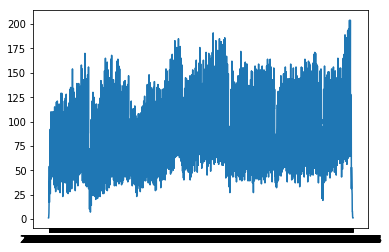

In [87]:
plt.plot(ahv_cnt_df[ahv_cnt_df['ntacode'] == 'MN17'].basis_dt, ahv_cnt_df[ahv_cnt_df['ntacode'] == 'MN17'].ahv_open_cnt)

In [88]:
ahv_cnt_df[ahv_cnt_df['ntacode'] == 'MN17'].basis_dt.min(), ahv_cnt_df[ahv_cnt_df['ntacode'] == 'MN17'].basis_dt.max() 

('2011-02-05', '2017-08-26')